# Sea Surface Current Prediction using LSTM

This notebook outlines the process of loading, inspecting, and preprocessing sea surface current data (`u` and `v` components) for training an LSTM model. The goal is to predict sea surface currents for the next 24 hours based on historical data.

### Import Libraries

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, InputLayer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

### Load and Inspect Data

The initial step involves loading the dataset using xarray, which facilitates working with multi-dimensional arrays, and inspecting its structure to understand the available dimensions, coordinates, and variables.

In [4]:
# Load the dataset
netcdf_file_path = "Data/24_months_SSC_Data.nc"

# Open the data
dataset = xr.open_dataset(netcdf_file_path)

# Print head of dataset
dataset.head()

<xarray.Dataset>
Dimensions:  (time: 5, lat: 5, lon: 5)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2021-01-01T04:00:00
  * lat      (lat) float32 35.74 35.77 35.79 35.81 35.83
  * lon      (lon) float32 13.68 13.72 13.76 13.8 13.84
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  BARK (measured);POZZ (measured);
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 14:45:58
    NC_GLOBAL.grid_type:               REGULAR
    NC_GLOBAL.Conventions:             CF-1.4
    ...                                ...
    NC_GLOBAL.grid_resolution:         3.0km
    NC_GLOBAL.geospatial_lat_max:      36.8802
    NC_GLOBAL.geospatial_lat_min:      35.7447
    NC_GLOBAL.geospatial_lon_max:      15.3804
    NC_GLOBAL.geospatial_lon_min:      13.6768
    NC_GLOBAL.netcdf_library_version:  v2

### Convert the dataset to a pandas DataFrame

In [5]:
# Convert the dataset to a pandas DataFrame
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Remove rows where 'u' has NaN values
df = df.dropna(subset=['u'])
df = df.dropna(subset=['v'])

df.index = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M:%S')

df

,time,lat,lon,u,v
time,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,36.011902,14.6908,-0.187088,-0.048105
2021-01-01 00:00:00,2021-01-01 00:00:00,36.011902,14.7314,-0.250971,-0.024680
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.5286,0.079402,0.039575
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.5692,-0.229349,0.057154
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.6908,-0.394889,0.063383
...,...,...,...,...,...
2022-12-31 23:00:00,2022-12-31 23:00:00,36.880199,14.1230,0.327331,-0.174509
2022-12-31 23:00:00,2022-12-31 23:00:00,36.880199,14.1635,0.400850,-0.164626
2022-12-31 23:00:00,2022-12-31 23:00:00,36.880199,14.2041,0.460808,-0.139945


### Geospatial Visualization
Define boundaries and coordinates for visualization

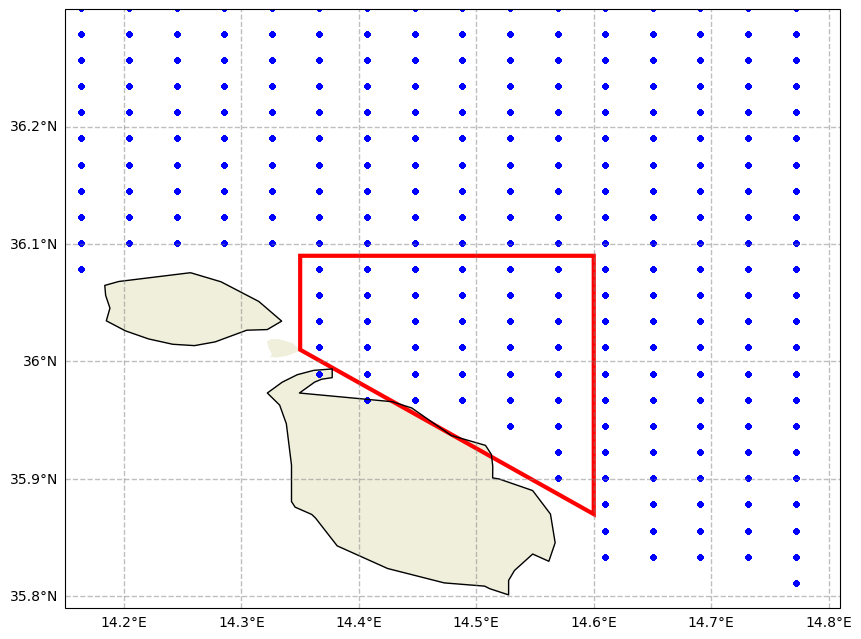

In [6]:
# Define the boundaries for map
boundaries = {
    'min_lon': 14.15,  
    'max_lon': 14.81,  
    'min_lat': 35.79,  
    'max_lat': 36.3   
}

# Define the coordinates 
polygon_coordinates = [
    (14.6, 35.87), 
    (14.35, 36.01), 
    (14.35, 36.09), 
    (14.6, 36.09), 
    (14.6, 35.87)
]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plotting all points within the boundary from the dataframe 'df'
ax.scatter(df['lon'], df['lat'], s=10, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# Create a red polygon and add it to the plot
red_polygon = mpatches.Polygon(polygon_coordinates, closed=True, edgecolor='red', facecolor='none', linewidth=3, transform=ccrs.Geodetic())
ax.add_patch(red_polygon)

# Gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

### Data Filtering 
Filter the DataFrame to include only data points within the specified polygon.

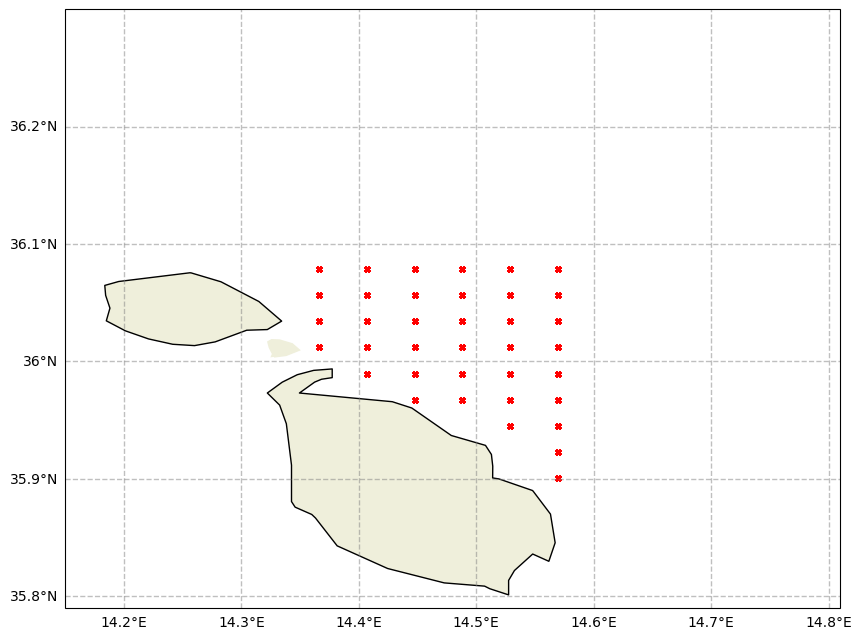

In [7]:
# Convert the polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Use the Path object to find points inside the polygon
inside_polygon = df.apply(lambda row: polygon_path.contains_point((row['lon'], row['lat'])), axis=1)
df_inside_polygon = df[inside_polygon]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plotting only the points within the polygon
ax.scatter(df_inside_polygon['lon'], df_inside_polygon['lat'], s=10, color='red', marker='x', alpha=0.5, transform=ccrs.Geodetic())

# Gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

### Data Preparation

In [8]:
# Convert the polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Prepare the coordinates as a list of tuples
coordinates = list(zip(df['lon'], df['lat']))

# Check if each coordinate is inside the polygon
inside_mask = [polygon_path.contains_point(coord) for coord in coordinates]

# Filter the DataFrame for points within the polygon
df_inside_polygon = df[inside_mask]

# Removing potential duplicates
df_inside_polygon = df_inside_polygon.drop_duplicates(subset=['lon', 'lat'])

# Count the number of points inside the polygon
num_points_inside_polygon = df_inside_polygon.shape[0]
print(f"Total number of points inside the polygon: {num_points_inside_polygon}\n")
print("Coordinates of the points inside the polygon:")

# Print out all of the coordinate pairs
coordinates_inside = df_inside_polygon[['lon', 'lat']].values
for lon, lat in coordinates_inside:
    print(f"({lon}, {lat})")

Total number of points inside the polygon: 37

Coordinates of the points inside the polygon:
(14.528599739074707, 36.03409957885742)
(14.569199562072754, 36.03409957885742)
(14.528599739074707, 36.056400299072266)
(14.569199562072754, 36.056400299072266)
(14.528599739074707, 36.07870101928711)
(14.569199562072754, 36.07870101928711)
(14.447500228881836, 36.07870101928711)
(14.447500228881836, 36.056400299072266)
(14.406900405883789, 36.07870101928711)
(14.528599739074707, 36.01190185546875)
(14.569199562072754, 36.01190185546875)
(14.48799991607666, 36.07870101928711)
(14.48799991607666, 36.03409957885742)
(14.48799991607666, 36.056400299072266)
(14.569199562072754, 35.96730041503906)
(14.569199562072754, 35.989601135253906)
(14.528599739074707, 35.989601135253906)
(14.48799991607666, 36.01190185546875)
(14.447500228881836, 36.03409957885742)
(14.447500228881836, 36.01190185546875)
(14.366399765014648, 36.07870101928711)
(14.447500228881836, 35.989601135253906)
(14.48799991607666, 35.9

In [9]:
# Assuming 'inside_mask' is a list of booleans indicating whether each point is inside the polygon
inside_mask = [polygon_path.contains_point((lon, lat)) for lon, lat in zip(df['lon'], df['lat'])]

# Convert 'inside_mask' to a pandas Series to use as a boolean indexer
inside_series = pd.Series(inside_mask, index=df.index)

# Filter the original DataFrame using the boolean Series
final_df = df[inside_series]

# Display the resulting DataFrame
final_df

,time,lat,lon,u,v
time,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.5286,0.079402,0.039575
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.5692,-0.229349,0.057154
2021-01-01 00:00:00,2021-01-01 00:00:00,36.056400,14.5286,0.046379,0.059340
2021-01-01 00:00:00,2021-01-01 00:00:00,36.056400,14.5692,-0.235254,0.081921
2021-01-01 00:00:00,2021-01-01 00:00:00,36.078701,14.5286,0.023732,0.085635
...,...,...,...,...,...
2022-12-31 23:00:00,2022-12-31 23:00:00,36.078701,14.4069,-0.147110,-0.092706
2022-12-31 23:00:00,2022-12-31 23:00:00,36.078701,14.4475,-0.092843,-0.124476
2022-12-31 23:00:00,2022-12-31 23:00:00,36.078701,14.4880,-0.047441,-0.130120


### Exctract data only for a single pair of coordinates

In [10]:
# Coordinates 
target_lat = 36.03409957885742
target_lon = 14.528599739074707

# Filter the DataFrame for the exact coordinates
df_point = final_df[(final_df['lat'] == target_lat) & (final_df['lon'] == target_lon)]

# Display the filtered DataFrame
df_point

,time,lat,lon,u,v
time,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,36.0341,14.5286,0.079402,0.039575
2021-01-01 13:00:00,2021-01-01 13:00:00,36.0341,14.5286,0.162881,-0.039021
2021-01-01 14:00:00,2021-01-01 14:00:00,36.0341,14.5286,0.144165,-0.023481
2021-01-01 15:00:00,2021-01-01 15:00:00,36.0341,14.5286,0.280085,-0.033406
2021-01-01 16:00:00,2021-01-01 16:00:00,36.0341,14.5286,0.115884,-0.089223
...,...,...,...,...,...
2022-12-31 19:00:00,2022-12-31 19:00:00,36.0341,14.5286,0.003522,-0.170710
2022-12-31 20:00:00,2022-12-31 20:00:00,36.0341,14.5286,0.000774,-0.120463
2022-12-31 21:00:00,2022-12-31 21:00:00,36.0341,14.5286,-0.030468,-0.092138


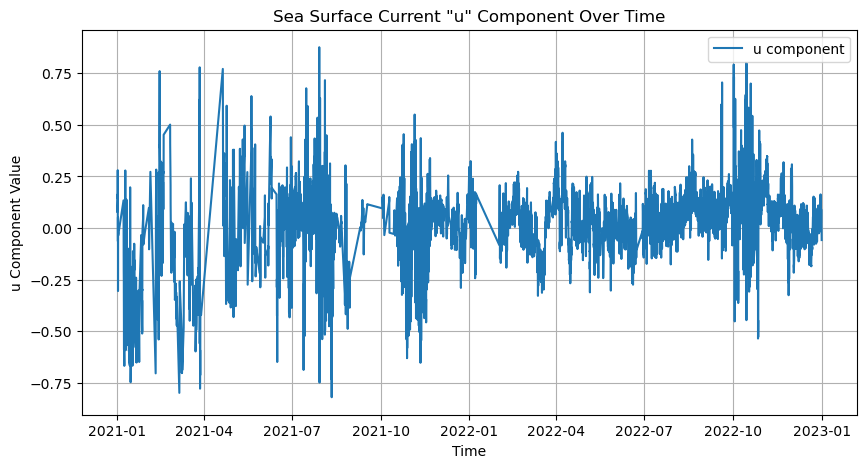

In [11]:
df1_u = df_point['u']

plt.figure(figsize=(10, 5))  
plt.plot(df1_u.index, df1_u, label='u component')  
plt.title('Sea Surface Current "u" Component Over Time')  
plt.xlabel('Time')  
plt.ylabel('u Component Value')  
plt.legend()  
plt.grid(True)  
plt.show()

### Convert the time series data into a format suitable for LSTM

In [12]:
def df_to_X_y(df_u, df_v, window_size=5):
    df_u_as_np = df_u.to_numpy()
    df_v_as_np = df_v.to_numpy()
    X = [] 
    y = []
    for i in range(len(df_u_as_np) - window_size):
        # Create a combined feature for each time step in the window
        combined_features = [[df_u_as_np[i+j], df_v_as_np[i+j]] for j in range(window_size)]
        X.append(combined_features)
        # The target remains the 'u' value at the next time step
        label = df_u_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

window_size = 1
X, y = df_to_X_y(df_point['u'], df_point['v'], window_size=window_size)
X.shape, y.shape

((8846, 1, 2), (8846,))

### Split the data

In [13]:
def train_val_test_split(X, y, train_size, val_size, test_size):
    # Calculate the indices for the end of each segment
    total_size = len(X)
    train_end = int(total_size * train_size)
    val_end = train_end + int(total_size * val_size)
    
    # Split the data
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

train_size = 0.70
val_size = 0.15
test_size = 1 - (train_size + val_size)

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, train_size, val_size, test_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6192, 1, 2), (6192,), (1326, 1, 2), (1326,), (1328, 1, 2), (1328,))

### Define & Compile the Model

In [14]:
# Define the model
model = Sequential()
model.add(InputLayer((window_size, 2)))
model.add(LSTM(128, return_sequences=True))  
model.add(Dropout(0.2))  
model.add(LSTM(64, return_sequences=True))  
model.add(Dropout(0.2))  
model.add(LSTM(32))  
model.add(Dropout(0.2))  
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))  
model.add(Dense(1, activation='linear'))

model.summary()

# Define ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(filepath="Data/LSTM/Saved_Models/lstm_single_u_target_diff_sequence_best_model",
                     save_best_only=True,
                     monitor='val_loss',  
                     mode='min',
                     verbose=0)   

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=8,
                               restore_best_weights=True,
                               min_delta=0.0001,  
                               verbose=1)             

# Compile the model
model.compile(loss=MeanSquaredError(),
              optimizer=Adam(learning_rate=0.001))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            67072     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                

### Train the Model

Epoch 1/100

184/194 [===========================>..] - ETA: 0s - loss: 0.1164INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


194/194 [==============================] - 16s 55ms/step - loss: 0.1130 - val_loss: 0.0442
Epoch 2/100
184/194 [===========================>..] - ETA: 0s - loss: 0.0255INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


194/194 [==============================] - 9s 45ms/step - loss: 0.0250 - val_loss: 0.0161
Epoch 3/100
185/194 [===========================>..] - ETA: 0s - loss: 0.0128INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


194/194 [==============================] - 8s 44ms/step - loss: 0.0128 - val_loss: 0.0111
Epoch 4/100
194/194 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 5/100
187/194 [===========================>..] - ETA: 0s - loss: 0.0116INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


194/194 [==============================] - 8s 44ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 6/100
184/194 [===========================>..] - ETA: 0s - loss: 0.0111INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


194/194 [==============================] - 10s 53ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 7/100
188/194 [============================>.] - ETA: 0s - loss: 0.0112INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


194/194 [==============================] - 10s 53ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 8/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 9/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 10/100
192/194 [============================>.] - ETA: 0s - loss: 0.0112INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


194/194 [==============================] - 9s 48ms/step - loss: 0.0112 - val_loss: 0.0105
Epoch 11/100
194/194 [==============================] - 1s 8ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 12/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 13/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 14/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 15/100
186/194 [===========================>..] - ETA: 0s - loss: 0.0111INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


194/194 [==============================] - 9s 47ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 16/100
194/194 [==============================] - 2s 8ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 17/100
193/194 [============================>.] - ETA: 0s - loss: 0.0111INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


194/194 [==============================] - 10s 52ms/step - loss: 0.0111 - val_loss: 0.0099
Epoch 18/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0111 - val_loss: 0.0101
Epoch 19/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 20/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0112 - val_loss: 0.0126
Epoch 21/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0111 - val_loss: 0.0101
Epoch 22/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 23/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 24/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 25/100
194/194 [==============================] - 3s 13ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 25: early stopping


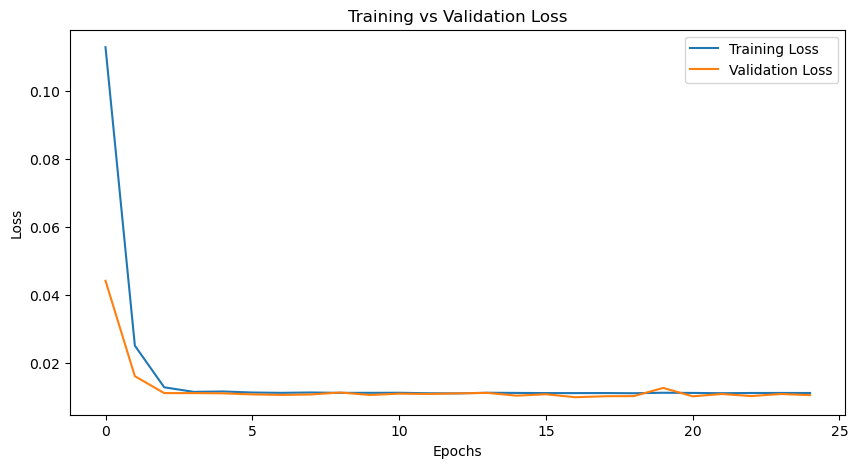

In [15]:
# Fit the model with the training data and validate with the validation data
history = model.fit(X_train, y_train,
                    batch_size=10,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=[model_checkpoint, early_stopping])

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation on Test Set

In [16]:
# Load the model
model = load_model("Data/LSTM/Saved_Models/lstm_single_u_target_diff_sequence_best_model")

# Make predictions on the test data
test_predictions = model.predict(X_test)

print("y_test shape:", y_test.shape)
print("test_predictions shape:", test_predictions.shape)

42/42 [==============================] - 2s 6ms/step
y_test shape: (1328,)
test_predictions shape: (1328, 1)


In [17]:
# Calculate metrics
mse_u = mean_squared_error(y_test, test_predictions)
m_ae_u = mean_absolute_error(y_test, test_predictions)
r2_u = r2_score(y_test, test_predictions)
explained_variance_u = explained_variance_score(y_test, test_predictions)

# Output the error metrics
print("Test MSE for 'u' component:", mse_u)
print("Test MAE for 'u' component:", m_ae_u)
print("Test R-squared for 'u' component:", r2_u)
print("Test Explained Variance for 'u' component:", explained_variance_u)

Test MSE for 'u' component: 0.002274376002692422
Test MAE for 'u' component: 0.028632800638690527
Test R-squared for 'u' component: 0.8267762283534899
Test Explained Variance for 'u' component: 0.8301774760450388


In [18]:
test_results = pd.DataFrame({
    'Test Predictions u': test_predictions.flatten(),
    'Actuals u': y_test
})

test_results

,Test Predictions u,Actuals u
0,0.107839,0.203187
1,0.198744,0.209414
2,0.203871,0.125163
3,0.134081,0.186031
4,0.185918,0.187845
...,...,...
1323,0.074991,0.003522
1324,0.014562,0.000774
1325,0.011223,-0.030468
1326,-0.022186,-0.026932


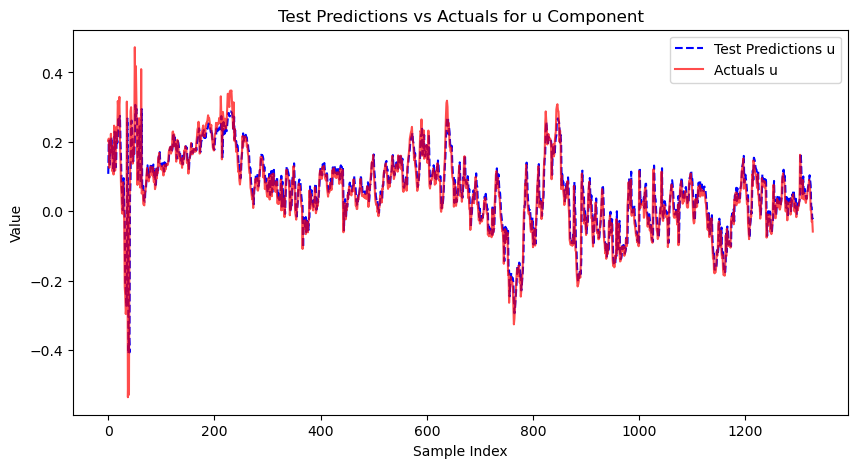

In [19]:
# Plot for the 'u' component test predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(test_results.index, test_results['Test Predictions u'], label='Test Predictions u', color='blue', linestyle='--')
plt.plot(test_results.index, test_results['Actuals u'], label='Actuals u', color='red', alpha=0.7)
plt.title('Test Predictions vs Actuals for u Component')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

### Making 24-Hour Predictions on the Test Set

First 24-Hour MSE: 0.0010795024124911048
First 24-Hour MAE: 0.02584895786081991
First 24-Hour R-squared: 0.3906415951600305
First 24-Hour Explained Variance: 0.6369375426805701


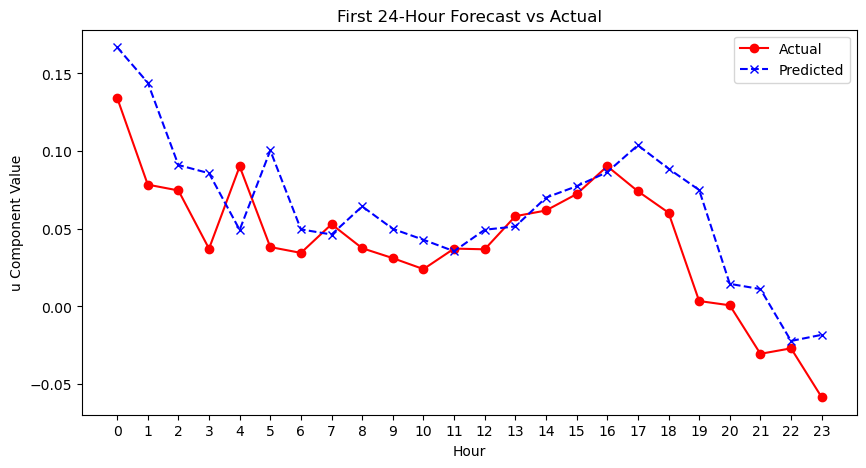

In [20]:
# Take the first 24 predictions for comparison
last_24_predictions = test_predictions[-24:]
last_24_actual = y_test[-24:]

# Flatten the predictions to make them a 1D array, if they're not already
first_24_predictions = last_24_predictions.flatten()

# Calculate metrics for the first 24-hour predictions
mse_24h = mean_squared_error(last_24_actual, first_24_predictions)
mae_24h = mean_absolute_error(last_24_actual, first_24_predictions)
r2_24h = r2_score(last_24_actual, first_24_predictions)
explained_variance_24h = explained_variance_score(last_24_actual, first_24_predictions)

# Output the error metrics for the 24-hour predictions
print("First 24-Hour MSE:", mse_24h)
print("First 24-Hour MAE:", mae_24h)
print("First 24-Hour R-squared:", r2_24h)
print("First 24-Hour Explained Variance:", explained_variance_24h)

# Plot for the first 24-hour predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(range(24), last_24_actual, label='Actual', marker='o', color='red')
plt.plot(range(24), first_24_predictions, label='Predicted', marker='x', color='blue', linestyle='--')
plt.title('First 24-Hour Forecast vs Actual')
plt.xlabel('Hour')
plt.ylabel('u Component Value')
plt.xticks(range(24))  # Set x-ticks to show each hour
plt.legend()
plt.show()